**Indian Restaurant datatset**: https://www.kaggle.com/henslersoftware/19560-indian-takeaway-orders


**Objective**: We want to forecast out order volume for staffing

**Notes**
- Find the number of daily orders
- Using pandasql since it'll be as close to what you'd be doing at work (working with SQL)

In [ ]:
!pip3 install pandasql


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=3c0da776c395ed3300d1c036d2e2d3f174ff95dbc76529d9a2a6ba4b52dc14fa
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [ ]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

orders=pd.read_csv('/content/drive/My Drive/Colab Notebooks/POC_Projects/restaurant-1-orders.csv')

Mounted at /content/drive


In [ ]:
orders.columns = ['number', 'timestamp', 'item', 'quantity', 'price', 'total_products_in_cart']

In [ ]:
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart
54683,15213,07/06/2019 18:12,Bhuna - Chicken,1,8.95,14
34042,9703,28/05/2018 19:36,Onion Bhajee,1,3.95,7


In [ ]:
orders['date'] = pd.to_datetime(orders['timestamp'].str[:10])

In [ ]:
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart,date
41778,3425,15/10/2016 18:28,Tandoori Chicken (1/4),1,4.95,8,2016-10-15
37379,4651,25/02/2017 17:36,Special Fried Rice,1,3.95,5,2017-02-25


In [ ]:
print(f"Total number of orders in dataset: {orders['number'].nunique()}")

Total number of orders in dataset: 13397


In [ ]:
def load_query(path):
    with open(path) as file:
        return file.read()

### Case 1: Direct Multistep Forecasting 

In [ ]:
query = load_query('/content/drive/My Drive/Colab Notebooks/POC_Projects/queries/daily_orders.sql')
daily_orders = pysqldf(query)

In [ ]:
daily_orders.sample(2)

,date,num_orders
15,2016-02-05,10
30,2016-03-15,4


In [ ]:
import logging
logging.getLogger().setLevel(logging.CRITICAL) # Prevent the matplotlib infos on categorical x-axis, removable

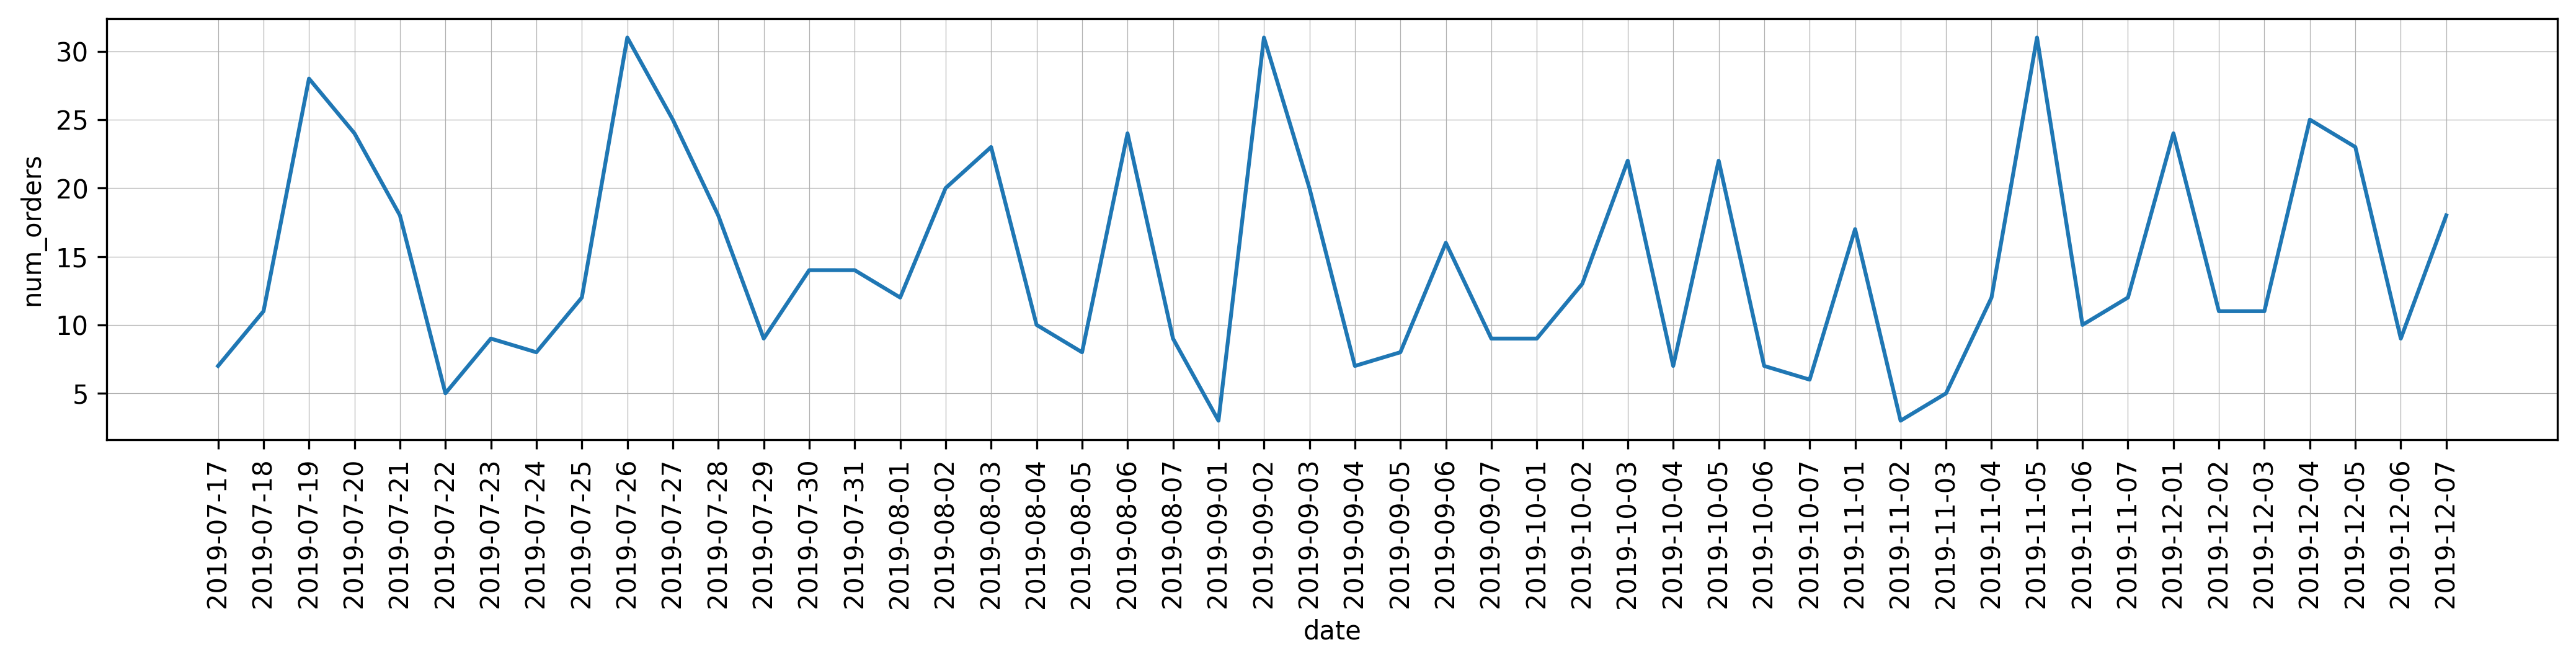

In [ ]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=daily_orders.tail(50), x='date', y='num_orders') #just considering LAST 50 orders
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

Too less orders daily to bother forecasting. Let's look at weekly order volume instead

In [ ]:
query = load_query('/content/drive/My Drive/Colab Notebooks/POC_Projects/queries/weekly_orders.sql')
weekly_orders = pysqldf(query)

In [ ]:
weekly_orders.sample(2) # week-wise, how many orders are coming, we are noting down on EVERY MONDAY

,week,num_orders
151,2018-11-26,84
100,2017-12-04,57


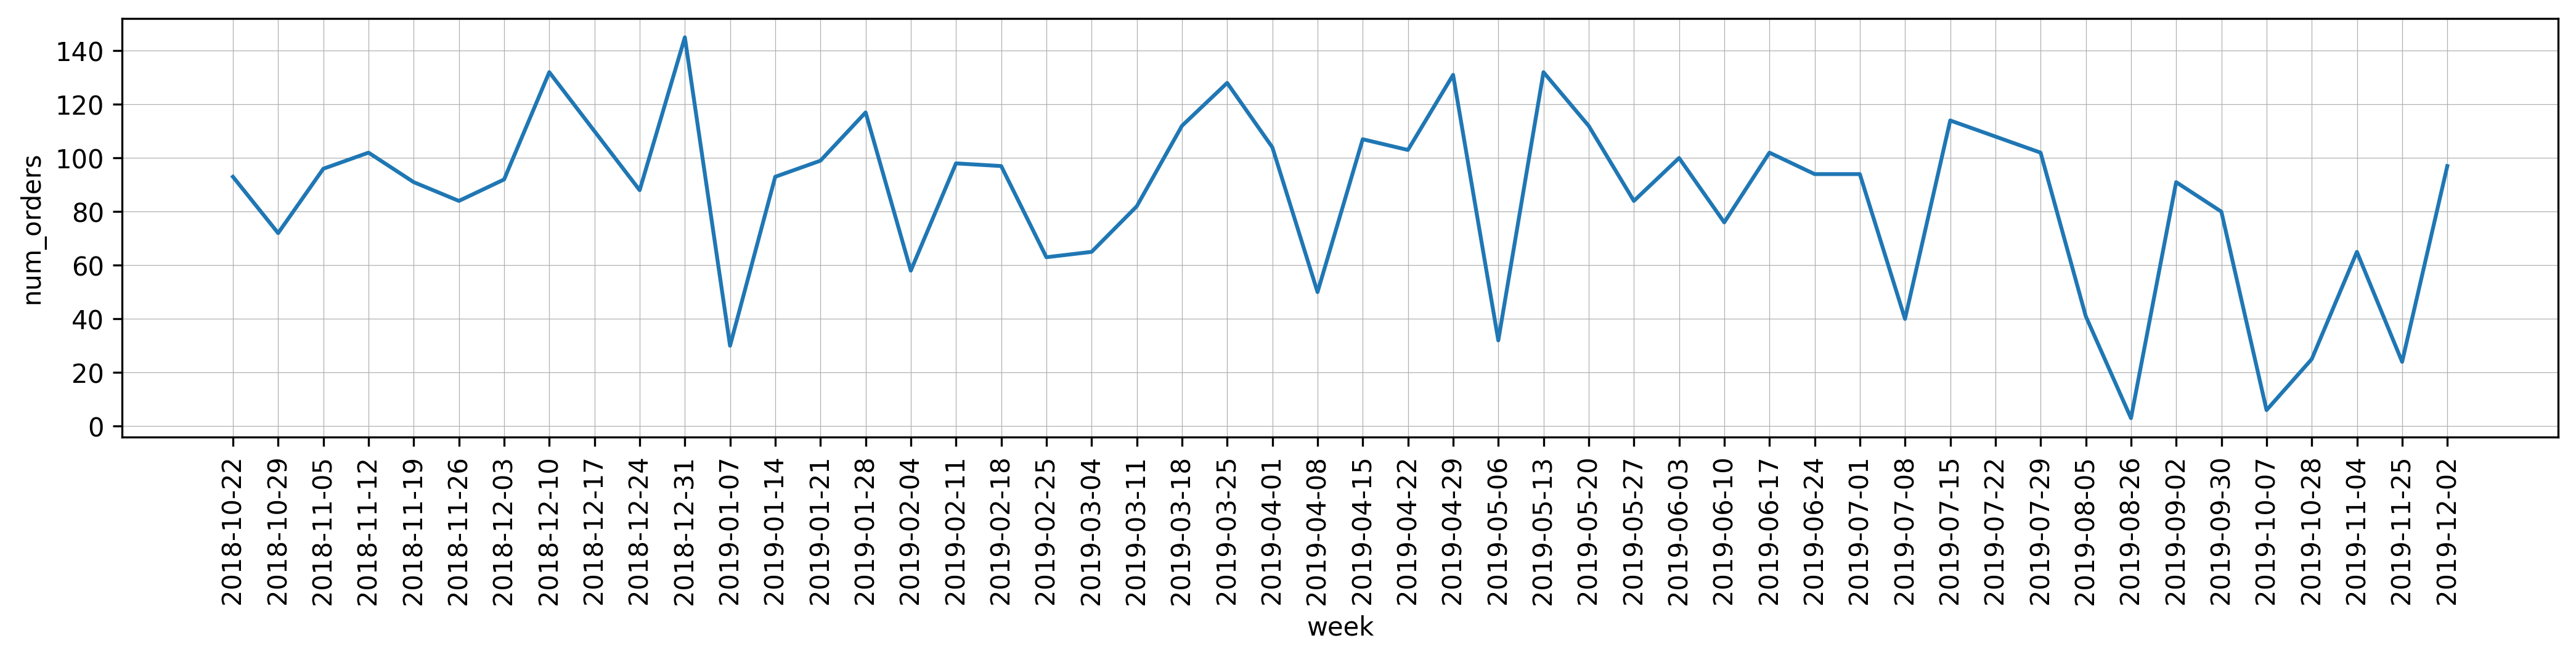

In [ ]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [ ]:
query = load_query('/content/drive/My Drive/Colab Notebooks/POC_Projects/queries/base.sql')
df = pysqldf(query)
df.to_csv('/content/drive/My Drive/Colab Notebooks/POC_Projects/Order Forecasting_Xgboost_dataset.csv')

In [ ]:
df.sample(3)

,week,order_count_7_day,order_count_30_day,label
105,2018-02-12,83,346,85
127,2018-07-16,130,392,72
110,2018-03-19,76,323,64


In [ ]:
features = ['order_count_7_day', 'order_count_30_day']
label = 'label'
test_df = df[df['week'] >= '2019-06-01']
train_df = df[df['week'] < '2019-06-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [ ]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01) #higher 'n_estimators' value is good, but you can fine tune as well
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[07:47:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:68.7982	validation_1-mae:72.7346
[1]	validation_0-mae:68.1262	validation_1-mae:72.1123
[2]	validation_0-mae:67.4607	validation_1-mae:71.4771
[3]	validation_0-mae:66.8018	validation_1-mae:70.8669
[4]	validation_0-mae:66.1494	validation_1-mae:70.2625
[5]	validation_0-mae:65.5032	validation_1-mae:69.6457
[6]	validation_0-mae:64.8635	validation_1-mae:69.053
[7]	validation_0-mae:64.23	validation_1-mae:68.4662
[8]	validation_0-mae:63.6026	validation_1-mae:67.9042
[9]	validation_0-mae:62.9814	validation_1-mae:67.3468
[10]	validation_0-mae:62.3663	validation_1-mae:66.7949
[11]	validation_0-mae:61.7571	validation_1-mae:66.2685
[12]	validation_0-mae:61.154	validation_1-mae:65.7273
[13]	validation_0-mae:60.5568	validation_1-mae:65.1914
[14]	validation_0-mae:59.9653	validation_1-mae:64.6802
[15]	validation_0-mae:59.3797	validation_1-mae:64.1548
[16]	va

XGBRegressor(learning_rate=0.01, n_estimators=500)

**Developer's note**: You might see slight increase in MAE. This XGBRegressor optimizes squared loss by default. There isn't support for MAE since gradient boosting (may) require non-zero second order derivatives. Need to confirm

In [ ]:
predictions = reg.predict(X_test)

In [ ]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)

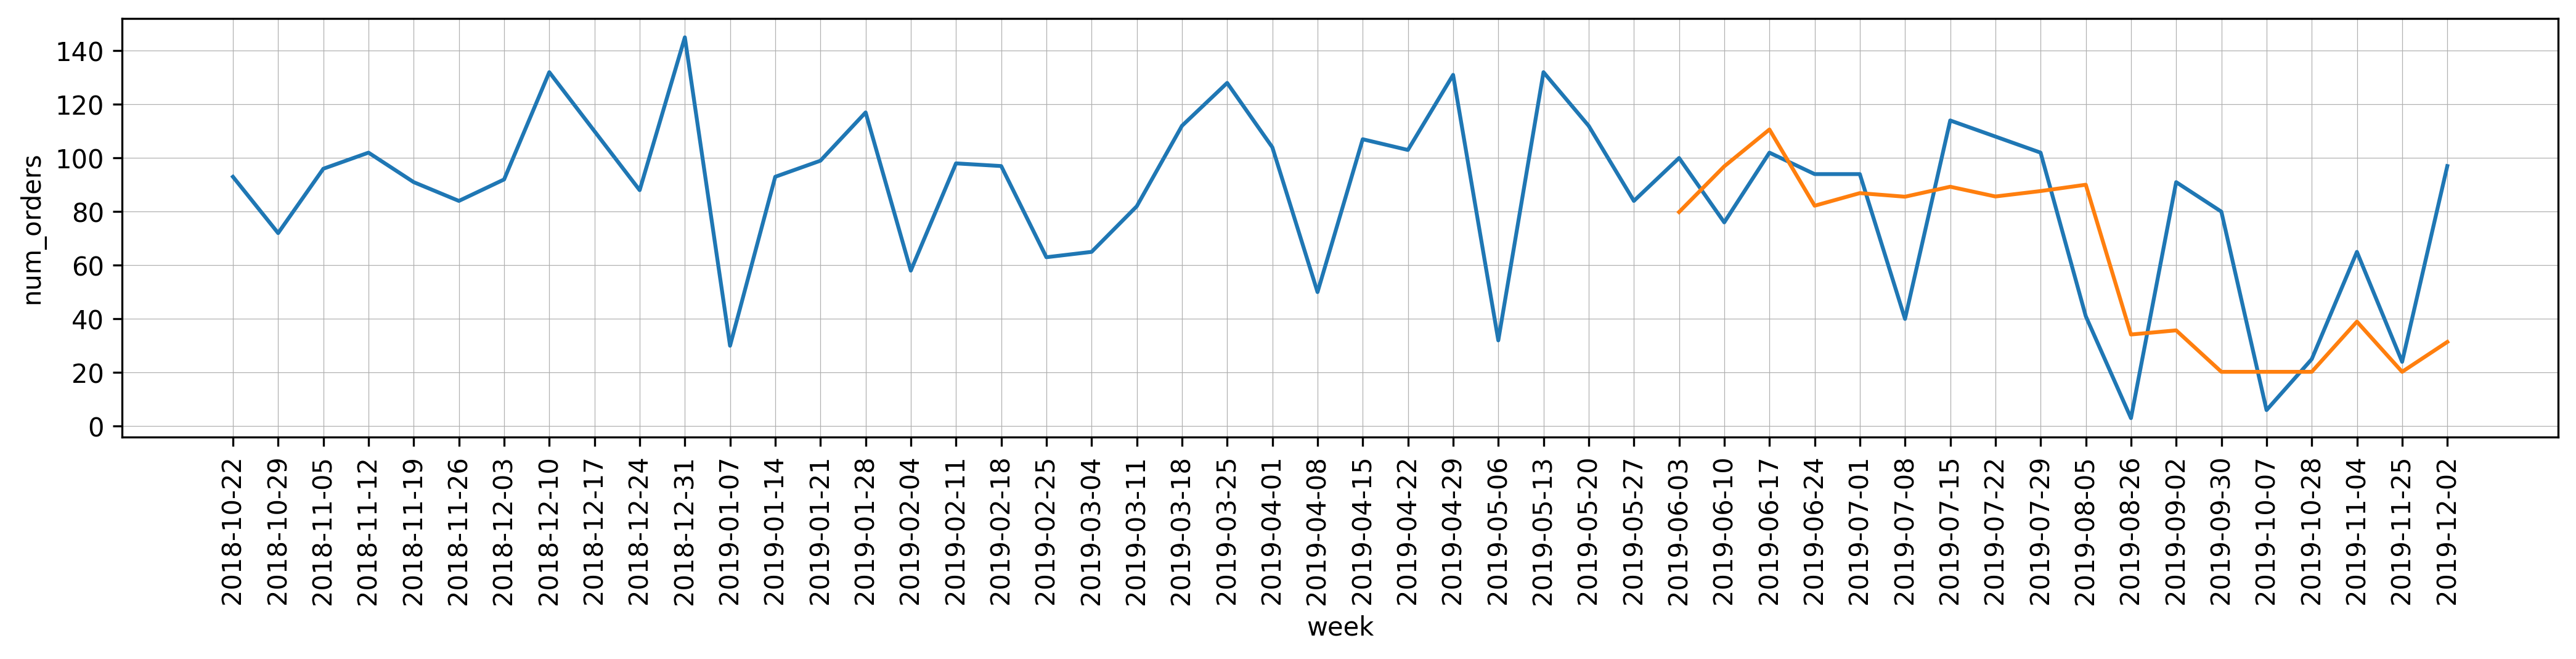

In [ ]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
sns.lineplot(data=test_df, x='week', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [ ]:
test_df#'order_count_7_day' are 'Orange line'; 'Label' are 'Blue line

,week,order_count_7_day,order_count_30_day,label,predictions
0,2019-06-03,84,416,100,79.849602
1,2019-06-10,100,428,76,96.885750
2,2019-06-17,76,433,102,110.632874
3,2019-06-24,102,414,94,82.207954
4,2019-07-01,94,389,94,86.905693
5,2019-07-08,94,366,40,85.569130
6,2019-07-15,40,377,114,89.289177
7,2019-07-22,114,381,108,85.654594
8,2019-07-29,108,393,102,87.677574
9,2019-08-05,102,406,41,90.037697


### Case 2: Prophet

### Case 2_1: Applied in actual Project

In [ ]:
!pip3 install pystan==2.19.1.1
!pip3 install fbprophet==0.7.1

from fbprophet import Prophet

train=data[(data['ds'] >= '2015-10-02') & (data['ds'] <= '2019-06-01')]
test=data[(data['ds'] > '2019-06-01')]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fbprophet import Prophet
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


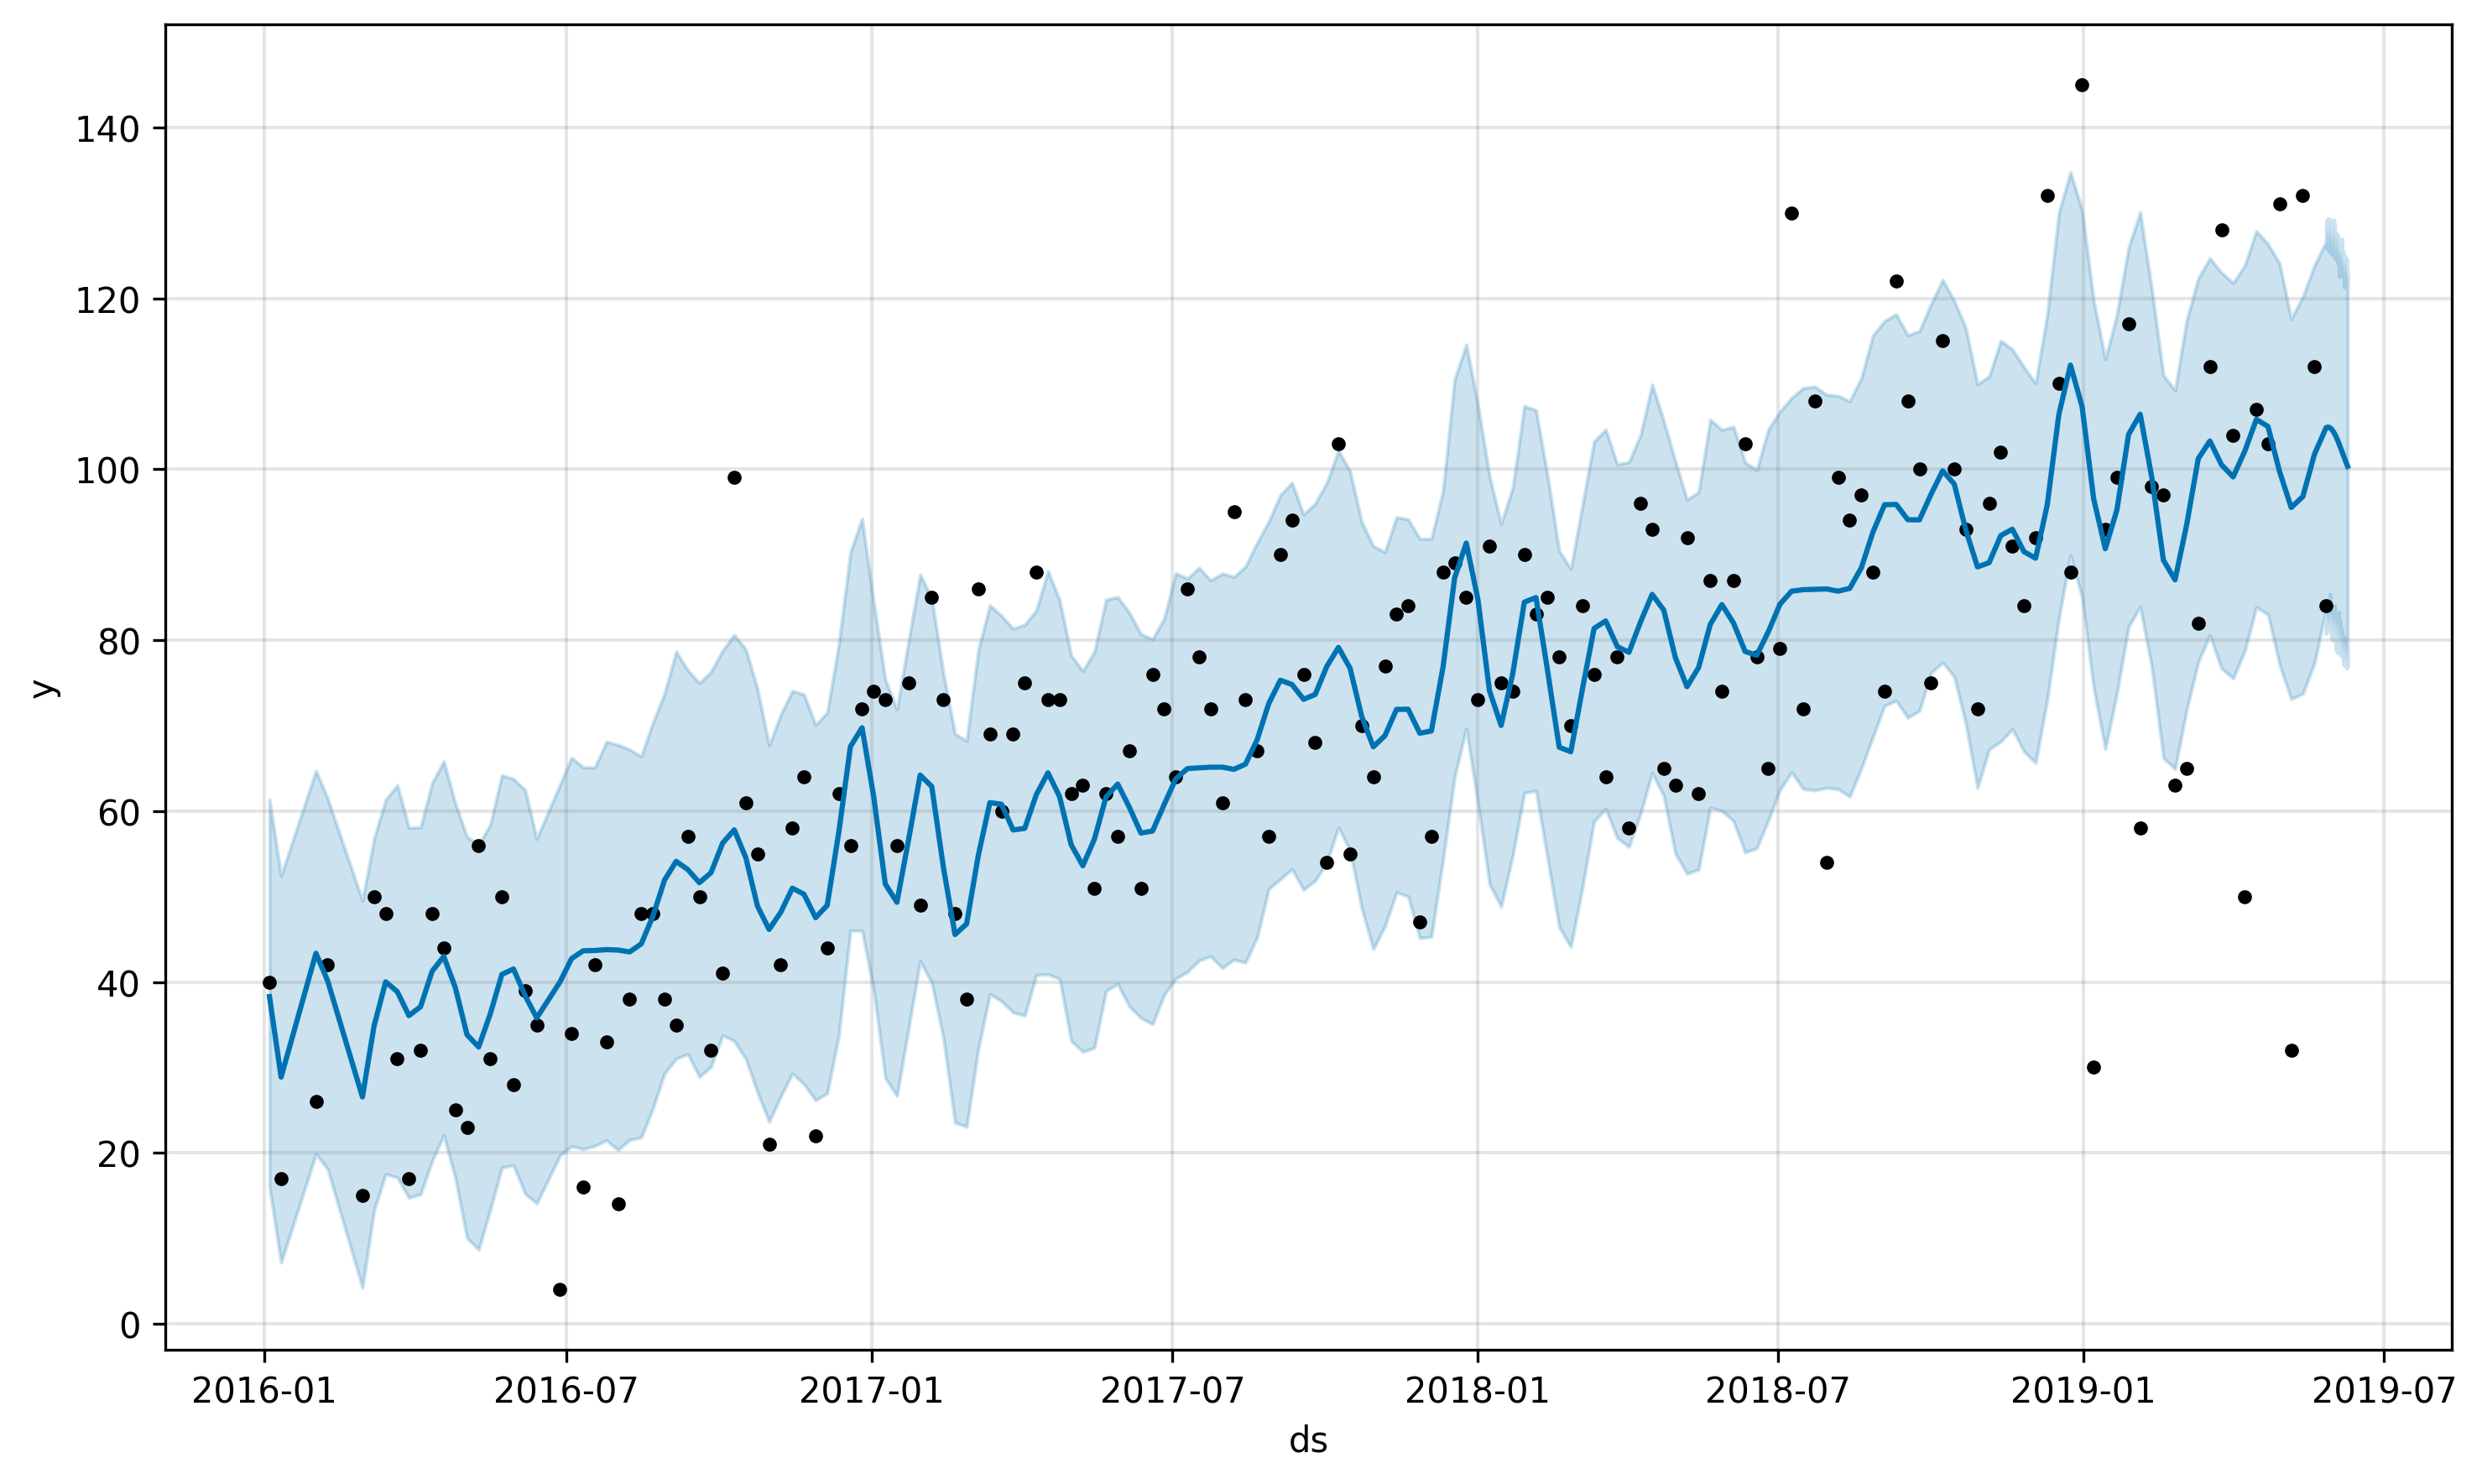

In [ ]:
future = m.make_future_dataframe(periods=130, freq='H')

future = m.make_future_dataframe(periods=312, freq='H')

fcst = m.predict(future)
fig = m.plot(fcst)

In [ ]:
future_final=future.copy()
future_final=future_final[future_final['ds'].dt.hour > 8][future_final['ds'].dt.hour < 19]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
